## Time Series Prediction using Machine Learning

### 1. Import Libraries and Fix Seeds

In [1]:
import os
import random
import numpy as np
import pandas as pd
from time import time
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

import torch
import torch.nn as nn

In [2]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

### 2. Utils

In [3]:
def import_data(dataset_path):
    dataset = pd.read_csv(dataset_path, parse_dates=True)

    cols_to_drop = ['Unnamed: 0',
                    'tripID',
                    'deviceID',
                    'accData',
                    'battery',
                    'eLoad',
                    'kpl',
                    'maf',
                    'rpm',
                    'tPos',
                    'fuel',
                    'gps_speed'
                    ]

    dataset.drop(cols_to_drop, axis=1, inplace=True)
    return dataset

In [4]:
def plot_data(dataset, index, feature):
    dataset.index = dataset[index]
    dataset.Datetime=pd.to_datetime(dataset[index])
    dataset.set_index(index)
    
    plt.figure(figsize=(15, 8))
    dataset[feature].plot()
    
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.xlabel('time', fontsize=18)
    plt.ylabel(feature, fontsize=18)
    plt.title('User Drive Cycle Tendency', fontsize=18)

In [5]:
def scaling_window(data, seq_length):
    x, y = list(), list()

    for i in range(len(data) - seq_length - 1):
        data_x = data[i:(i+seq_length)]
        data_y = data[i+seq_length]
        x.append(data_x)
        y.append(data_y)
    
    x, y = np.array(x), np.array(y)
    
    return x, y

In [6]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

In [7]:
def mean_percentage_error(y_true, y_pred):
    return np.mean(percentage_error(np.asarray(y_true), np.asarray(y_pred))) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [8]:
def test_metrics(label, pred_test, model):
    
    test_mae = mean_absolute_error(label, pred_test)
    test_mse = mean_squared_error(label, pred_test, squared=True)
    test_rmse = mean_squared_error(label, pred_test, squared=False)
    test_mpe = mean_percentage_error(label, pred_test)
    test_mape = mean_absolute_percentage_error(label, pred_test)
    test_r2 = r2_score(label, pred_test)
    
    print("Test {}".format(model.__class__.__name__))
    print(" MAE : {:.4f}".format(test_mae))
    print(" MSE : {:.4f}".format(test_mse))
    print("RMSE : {:.4f}".format(test_rmse))
    print(" MPE : {:.4f}".format(test_mpe))
    print("MAPE : {:.4f}".format(test_mape))
    print(" R^2 : {:.4f}".format(test_r2))

## 3. Prepare Dataset

In [9]:
dataset_path = './combined/33_sep.csv'

dataset = import_data(dataset_path)

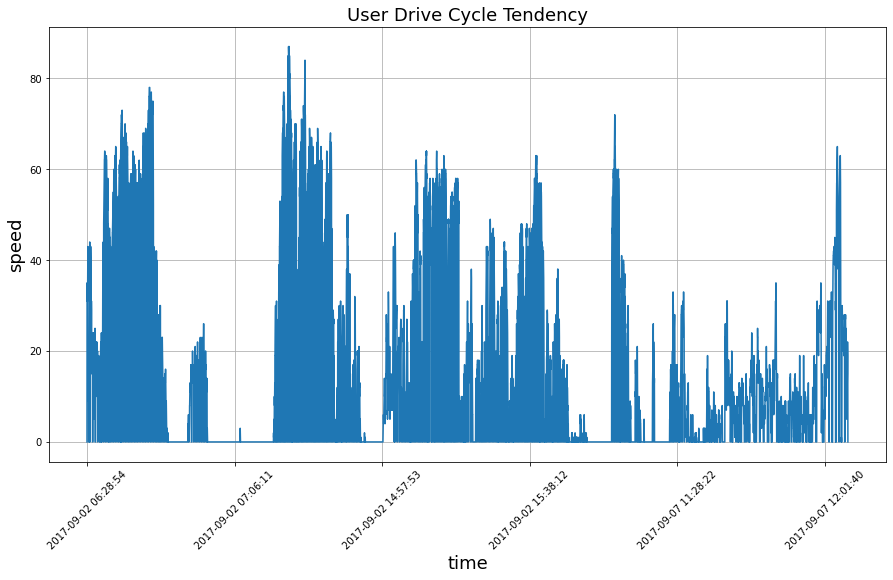

In [10]:
index = 'timeStamp'
feature = 'speed'

plot_data(dataset, index, feature)

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset[feature].to_numpy().reshape(-1, 1))

seq_length = 60
x, y = scaling_window(scaled_data, seq_length)

In [12]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

train_X = x[0 : train_size]
train_Y = y[0 : train_size]
train_date = dataset[index][0 : train_size]

test_X = x[train_size : len(x)]
test_Y = y[train_size : len(y)]
test_date = dataset[index][train_size : len(y)]

In [13]:
num_samples, x, y = train_X.shape
train_X = train_X.reshape((num_samples, x*y))

num_samples, x, y = test_X.shape
test_X = test_X.reshape((num_samples, x*y))

In [14]:
test_Y = scaler.inverse_transform(test_Y.reshape(-1, 1))

### 4. Prediction
#### 4.1 Decision Tree Regressor

In [15]:
params = {
    "criterion": ["mse", "mae"],
    "max_depth": [1, 2, 5, 10, 20]
}

dtr = DecisionTreeRegressor()

In [16]:
t1 = time()

grid = GridSearchCV(dtr, params)
model = grid.fit(train_X, train_Y.ravel())

print("Best Params: ", grid.best_params_)
print("Time taken: {:.2f}s".format(time() - t1))

Best Params:  {'criterion': 'mse', 'max_depth': 5}
Time taken: 83.31s


In [17]:
pred_dtr = model.predict(test_X)
pred_dtr = scaler.inverse_transform(pred_dtr.reshape(-1, 1))

#### 4.2 Support Vector Regressor

In [18]:
params = {
    "C": [0.1, 1.0, 10.0],
    "kernel": ["linear", "poly"]
}

svr = SVR()

In [19]:
t1 = time()

grid = GridSearchCV(svr, params)
model = grid.fit(train_X, train_Y.ravel())

print("Best Params : ", grid.best_params_)
print("Time taken: {:.2f}s".format(time() - t1))

Best Params :  {'C': 0.1, 'kernel': 'linear'}
Time taken: 297.96s


In [20]:
pred_svr = model.predict(test_X)
pred_svr = scaler.inverse_transform(pred_svr.reshape(-1, 1))

#### 4.3 Adaboost Regressor

In [21]:
params = {
    "n_estimators": [20, 50, 100],
    "learning_rate": [0.01, 0.001]
}

ada = AdaBoostRegressor()

In [22]:
t1 = time()

grid = GridSearchCV(ada, params)
model = grid.fit(train_X, train_Y.ravel())

print("Best Params : ", grid.best_params_)
print("Time taken: {:.2f}s".format(time() - t1))

Best Params :  {'learning_rate': 0.001, 'n_estimators': 50}
Time taken: 52.33s


In [23]:
pred_ada = model.predict(test_X)
pred_ada = scaler.inverse_transform(pred_ada.reshape(-1, 1))

### 5. Quantitative Results and Plots

In [24]:
test_metrics(test_Y, pred_dtr, dtr)

Test DecisionTreeRegressor
 MAE : 2.6269
 MSE : 23.1868
RMSE : 4.8153
 MPE : 10.4706
MAPE : 32.8051
 R^2 : 0.8377


In [25]:
test_metrics(test_Y, pred_svr, svr)

Test SVR
 MAE : 2.9449
 MSE : 20.6222
RMSE : 4.5412
 MPE : -2.7192
MAPE : 37.7195
 R^2 : 0.8557


In [26]:
test_metrics(test_Y, pred_ada, ada)

Test AdaBoostRegressor
 MAE : 3.8812
 MSE : 28.5349
RMSE : 5.3418
 MPE : 30.2828
MAPE : 41.3337
 R^2 : 0.8003


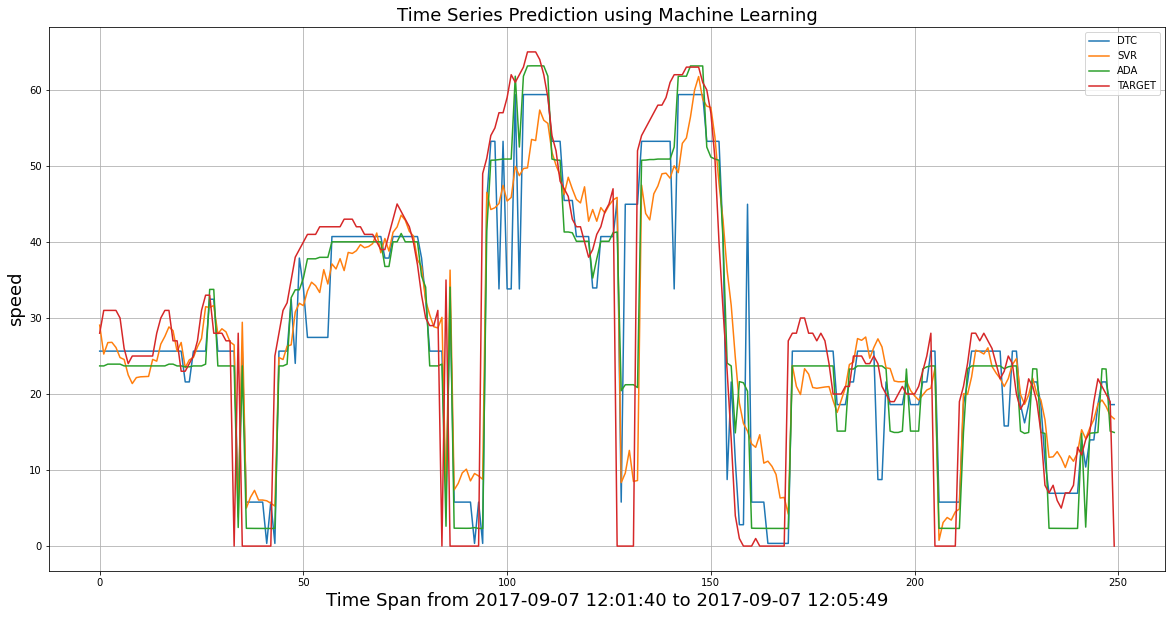

In [29]:
start_idx = 1800

plt.figure(figsize=(20, 10))

plt.plot(pred_dtr[start_idx:], label='DTC')
plt.plot(pred_svr[start_idx:], label='SVR')
plt.plot(pred_ada[start_idx:], label='ADA')
plt.plot(test_Y[start_idx:], label='TARGET')

plt.xlabel('Time Span from {} to {}'.format(test_date[start_idx], test_date[-1]) , fontsize=18)
plt.ylabel(feature, fontsize=18)
plt.grid(True)
plt.legend()

plt.title('Time Series Prediction using Machine Learning', fontsize=18)
plt.savefig('./ts_using_ml.png')
plt.show()